In [3]:
import os, math, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

# === SAMAKAN transform, batch_size, split, epoch, optimizer, LR DENGAN TAHAP 1 ===
IMG_ROOT = "train"  # <-- GANTI sesuai dataset kamu
CSV_PATH = "train.csv"       # nama file CSV Tahap 1

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_ROOT, transform=transform)

# Split yang sama dengan Tahap 1 (mis. 80:20). 
# Jika Tahap 1 pakai seed tertentu, set di sini juga agar split identik.
generator = torch.Generator().manual_seed(42)  # GANTI jika Tahap 1 beda seed
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

BATCH_SIZE = 32   # <-- SAMAKAN
EPOCHS = 10       # <-- SAMAKAN
LR = 1e-3         # <-- SAMAKAN
OPTIM = "adam"    # <-- SAMAKAN ('adam' atau 'sgd' dsb.)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlockSE(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SEBlock(planes, reduction)  # << integrasi SE
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)   # << apply SE di sini

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stages: [3,4,6,3] untuk ResNet-34
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:   # ✅ tambahkan pengecekan
                    nn.init.constant_(m.bias, 0)

        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # jika dimensi berubah (stride!=1 atau channel berubah), siapkan downsample
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet34_se(num_classes=5):
    return ResNet(BasicBlockSE, [3,4,6,3], num_classes=num_classes)

model = resnet34_se(num_classes=5).to(device)


In [6]:
criterion = nn.CrossEntropyLoss()
if OPTIM.lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=LR)
elif OPTIM.lower() == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, nesterov=False)
else:
    raise ValueError("OPTIM harus 'adam' atau 'sgd' (samakan dg Tahap 1).")

In [14]:
# =====================================================
# DataLoader (FIX: num_workers=0 untuk Windows)
# =====================================================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# =====================================================
# Training utilities
# =====================================================
criterion = nn.CrossEntropyLoss()
if OPTIM.lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=LR)
elif OPTIM.lower() == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, nesterov=False)
else:
    raise ValueError("OPTIM harus 'adam' atau 'sgd'.")

def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return loss, acc

# =====================================================
# Training loop
# =====================================================
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

if __name__ == "__main__":
    for epoch in range(EPOCHS):
        tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
        va_loss, va_acc = run_epoch(model, val_loader, train=False)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss {tr_loss:.4f} | Val Loss {va_loss:.4f} | "
              f"Train Acc {tr_acc:.2f}% | Val Acc {va_acc:.2f}%")
              
    print("🎉 Training selesai!")

    


c:\Users\Asus\miniconda3\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Train Loss 1.4155 | Val Loss 1.7903 | Train Acc 40.41% | Val Acc 49.10%
Epoch 2/10 | Train Loss 1.0890 | Val Loss 1.7550 | Train Acc 56.88% | Val Acc 43.24%
Epoch 2/10 | Train Loss 1.0890 | Val Loss 1.7550 | Train Acc 56.88% | Val Acc 43.24%
Epoch 3/10 | Train Loss 1.0254 | Val Loss 1.1993 | Train Acc 62.87% | Val Acc 55.86%
Epoch 3/10 | Train Loss 1.0254 | Val Loss 1.1993 | Train Acc 62.87% | Val Acc 55.86%
Epoch 4/10 | Train Loss 0.8620 | Val Loss 2.0335 | Train Acc 68.17% | Val Acc 46.40%
Epoch 4/10 | Train Loss 0.8620 | Val Loss 2.0335 | Train Acc 68.17% | Val Acc 46.40%
Epoch 5/10 | Train Loss 0.7515 | Val Loss 1.4756 | Train Acc 72.91% | Val Acc 54.95%
Epoch 5/10 | Train Loss 0.7515 | Val Loss 1.4756 | Train Acc 72.91% | Val Acc 54.95%
Epoch 6/10 | Train Loss 0.6561 | Val Loss 1.3711 | Train Acc 77.54% | Val Acc 59.46%
Epoch 6/10 | Train Loss 0.6561 | Val Loss 1.3711 | Train Acc 77.54% | Val Acc 59.46%
Epoch 7/10 | Train Loss 0.6601 | Val Loss 0.8482 | Train Acc 77.4

In [15]:
torch.save(model.state_dict(), "resnet34-se_food5.pth")
np.savez("resnet34-se_history.npz",
        train_loss=np.array(history["train_loss"]),
        val_loss=np.array(history["val_loss"]),
        train_acc=np.array(history["train_acc"]),
        val_acc=np.array(history["val_acc"]),
        meta=np.array([json.dumps({
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "lr": LR,
            "optimizer": OPTIM,
            "split":"80/20",
            "seed": 42
        })], dtype=object))
print("Saved: resnet34-se_food5.pth & resnet34-se_history.npz")



Saved: resnet34-se_food5.pth & resnet34-se_history.npz


Total model yang dimuat: 3


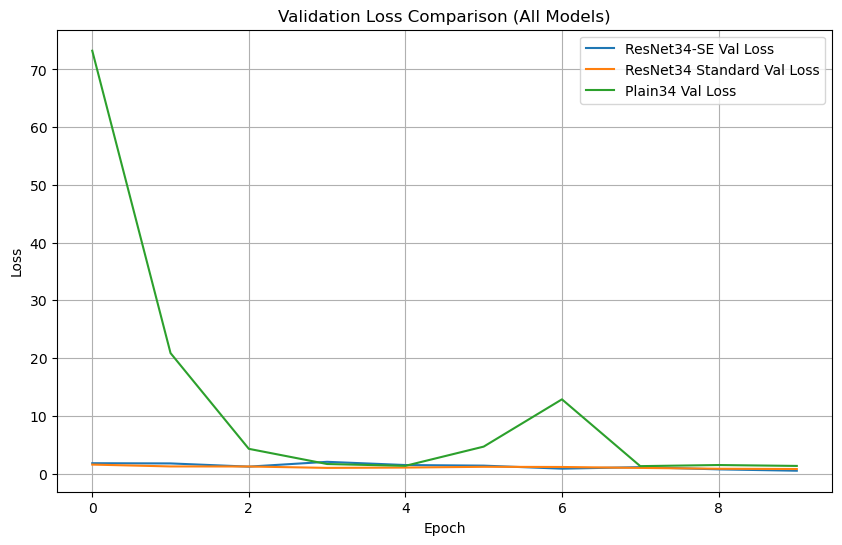

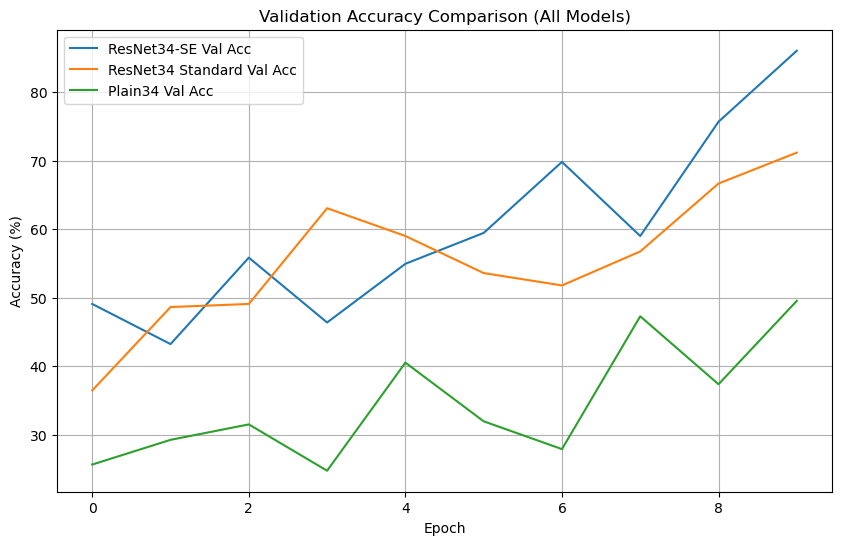


=== Perbandingan Kinerja (Epoch Terakhir) ===
            Model Train Loss Val Loss Train Acc % Val Acc %
          Plain34     1.1168   1.3219       53.95     49.55
ResNet34 Standard     0.9543   0.7861       67.16     71.17
      ResNet34-SE     0.4705   0.4909       85.21     86.04


In [16]:
# Tentukan nama file yang akan dimuat
STD_FILE = "resnet34_history.npz"
PLAIN_FILE = "plain34_history.npz"

# --- Fungsi Utilitas ---
def safe_last(h_dict, key):
    lst = h_dict.get(key, []) 
    return lst[-1] if lst else np.nan

def load_npz_history(file_path):
    """Helper function untuk memuat history dari file .npz"""
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        return {k: v.tolist() for k, v in data.items() if k in ["train_loss", "val_loss", "train_acc", "val_acc"]}
    return None

# --- Pengumpulan History ---

# Asumsi: variabel 'history' (ResNet34-SE) sudah ada di memori global
all_histories = {
    "ResNet34-SE": history 
}
models_to_plot = ["ResNet34-SE"]

# Muat ResNet-34 Standar
hist_std = load_npz_history(STD_FILE)
if hist_std:
    all_histories["ResNet34 Standard"] = hist_std
    models_to_plot.insert(0, "ResNet34 Standard") # Masukkan di awal

# Muat Plain34
hist_plain = load_npz_history(PLAIN_FILE)
if hist_plain:
    all_histories["Plain34"] = hist_plain
    models_to_plot.insert(0, "Plain34") # Masukkan di awal

print(f"Total model yang dimuat: {len(all_histories)}")

# --- Plotting Overlay (Loss dan Accuracy) ---
plt.figure(figsize=(10, 6))
for name, hist in all_histories.items():
    plt.plot(hist["val_loss"], label=f"{name} Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss Comparison (All Models)"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for name, hist in all_histories.items():
    plt.plot(hist["val_acc"], label=f"{name} Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Validation Accuracy Comparison (All Models)"); plt.legend(); plt.grid(True)
plt.show()

# --- Tabel Ringkas (Epoch Terakhir) ---
summary_data = {
    "Model": [],
    "Train Loss": [],
    "Val Loss": [],
    "Train Acc %": [],
    "Val Acc %": []
}

# Urutan yang lebih baik (Plain -> Std -> SE)
display_order = [m for m in ["Plain34", "ResNet34 Standard", "ResNet34-SE"] if m in all_histories]

for name in display_order:
    hist = all_histories[name]
    summary_data["Model"].append(name)
    summary_data["Train Loss"].append(safe_last(hist, "train_loss"))
    summary_data["Val Loss"].append(safe_last(hist, "val_loss"))
    summary_data["Train Acc %"].append(safe_last(hist, "train_acc"))
    summary_data["Val Acc %"].append(safe_last(hist, "val_acc"))

df = pd.DataFrame(summary_data)

# Formatting (seperti sebelumnya)
df = df.fillna('N/A')
df['Train Loss'] = df['Train Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
df['Val Loss'] = df['Val Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
df['Train Acc %'] = df['Train Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)
df['Val Acc %'] = df['Val Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)

print("\n=== Perbandingan Kinerja (Epoch Terakhir) ===")
print(df.to_string(index=False))

In [17]:
# Tentukan nama file history untuk Baseline
STD_FILE = "resnet34_history.npz"   # History ResNet34 Standar
PLAIN_FILE = "plain34_history.npz" # History Plain34

# --- Fungsi Utilitas ---
def safe_last(h_dict, key):
    # Mengambil elemen terakhir secara aman
    lst = h_dict.get(key, []) 
    return lst[-1] if lst else np.nan

def load_npz_history(file_path):
    """Fungsi untuk memuat history dari file .npz"""
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        return {k: v.tolist() for k, v in data.items() if k in ["train_loss", "val_loss", "train_acc", "val_acc"]}
    return None

# --- Pengumpulan History ---

# 1. ResNet34-SE (history dari memori/global)
all_histories = {
    "ResNet34-SE": history 
}

# 2. Muat ResNet-34 Standar
hist_std = load_npz_history(STD_FILE)
if hist_std:
    all_histories["ResNet34 Standard"] = hist_std

# 3. Muat Plain34
hist_plain = load_npz_history(PLAIN_FILE)
if hist_plain:
    all_histories["Plain34"] = hist_plain

print(f"[Info] Total model yang akan dibandingkan: {len(all_histories)}")

# --- Pembuatan Tabel Ringkas (Epoch Terakhir) ---
summary_data = {
    "Model": [],
    "Train Loss": [],
    "Val Loss": [],
    "Train Acc %": [],
    "Val Acc %": []
}

# Tentukan urutan tampilan di tabel (misal: Plain -> Std -> SE)
display_order = [m for m in ["Plain34", "ResNet34 Standard", "ResNet34-SE"] if m in all_histories]

for name in display_order:
    hist = all_histories[name]
    summary_data["Model"].append(name)
    summary_data["Train Loss"].append(safe_last(hist, "train_loss"))
    summary_data["Val Loss"].append(safe_last(hist, "val_loss"))
    summary_data["Train Acc %"].append(safe_last(hist, "train_acc"))
    summary_data["Val Acc %"].append(safe_last(hist, "val_acc"))

df = pd.DataFrame(summary_data)

# Formatting hasil
df = df.fillna('N/A')
df['Train Loss'] = df['Train Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
df['Val Loss'] = df['Val Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
df['Train Acc %'] = df['Train Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)
df['Val Acc %'] = df['Val Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)

print("\n=== Tabel Perbandingan Kinerja Akhir ===")
print(df.to_string(index=False))

# Jika Anda ingin membuat plot juga, tambahkan kode plot dari jawaban sebelumnya di bawah ini
# ... (Kode Plotting Overlay) ...

[Info] Total model yang akan dibandingkan: 3

=== Tabel Perbandingan Kinerja Akhir ===
            Model Train Loss Val Loss Train Acc % Val Acc %
          Plain34     1.1168   1.3219       53.95     49.55
ResNet34 Standard     0.9543   0.7861       67.16     71.17
      ResNet34-SE     0.4705   0.4909       85.21     86.04
